In [26]:
import pandas as pd
import os
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import time

import statsmodels.formula.api as smf
from statsmodels.tools import add_constant as ac
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [27]:
def Daterize(df):
    df['HrMn'] = df['HrMn'].astype(str)
    df['Mn'] = df['HrMn'].str[-2:].astype(int)
    df['Hr'] = df['HrMn'].astype(int).floordiv(100).astype(str).str.replace('24','00')
    df.loc[df['Hr'] == '00',['DOY']]+=1
    df['Hr'] = df['Hr'].astype(int)
    df = df.set_index(pd.to_datetime(df['Year'] * 10000000 + df['DOY']*10000+df['Hr']*100+df['Mn'], format='%Y%j%H%M'))
    return(df)

def Deptherize(df,adj):
    df = pd.concat([df,adj],axis=1,join = 'inner')
    df['Table'] = -.01*df['Probe'] + df['Depth']
    return(df)

def Droperize(df,drop):
    df = df.drop(drop, axis=1)
    return(df)

def Fluxerize(df,df2,key):
    Coef = [6.37192,6.27367,6.27367]
    df['HFP'] = df['HFP']*Coef[int(key)-1]
    Bulk_Density = 200 ## kg/m3 -- estimate
    Water_Density = 1000 ## kg/m3
    C_Dry = 840 ## j/kg/C
    C_Wet = 4184 ## j/kg/C
    df['Tdiff'] = df['Temp_2_5'].diff()
    df2.loc[df2['Period']<20,['Period']]=np.nan
    df2['Period'] = df2['Period']**.5
    df2['VWC'] = .5114*df2['Period']**3 -7.9851* df2['Period']**2 + 47.318*df2['Period'] -51.508
    df['cs'] = Bulk_Density *( C_Dry + C_Wet*Water_Density/Bulk_Density*df2['VWC']*.01)
    df['S'] = df['Tdiff']*df['cs']*.05/1800
    return(df,df2)

def Spike_Removalize(df,key):
    if key == '1':
        df.loc[df['VWC']<.17,'VWC']=np.nan
    if key == '2' or key == '3':
        df.loc[df['VWC']<.08,'VWC']=np.nan
    return(df)
def Resampleize(df):    
    df = df.resample('30T').asfreq().interpolate('linear')
    return(df)

def Processize(dr,file,key,ADJ):
    name = dr+'Water'+file
    Water = pd.read_csv(name)
    Water = Daterize(Water)
    if key == '1':
        Water.loc[Water.index<'2017-06-23 13:00:00','Depth']=np.nan
    Water = Deptherize(Water,ADJ)
    Water = Droperize(Water,['Year','DOY','HrMn','Hr','Mn','Date'])
    Water = Spike_Removalize(Water,key)
    Water = Resampleize(Water)
    
    Energy = pd.read_csv(dr+'Energy'+file)
    Energy = Daterize(Energy)
    Energy,Water = Fluxerize(Energy,Water,key)
    Energy = Droperize(Energy,['Year','DOY','HrMn','Hr','Mn','BattV','Sig','Itemp','BTemp_Max','MTemp_Max','TTemp_Max','HFP_Max','BTemp_Min','MTemp_Min','TTemp_Min','HFP_Min'])
    Energy.loc[Energy['HFP']<-100,'HFP']=np.nan
    Energy.loc[Energy.index<'2017-06-23 14:00:00','Temp_2.5']=np.nan
    
    Water = Water.add_suffix('_'+key)
    Energy = Energy.add_suffix('_'+key)
    return(Energy,Water)

In [35]:
Conductivity_2 = np.asanyarray([0.2,0.39,0.5,0.8,1.15])
Conductivity_4 = np.asanyarray([0.18,0.35,0.5,0.7,0.9])
VWC = np.asanyarray([.2,.4,.6,.8,1])
d = {'2':Conductivity_2,'4':Conductivity_4,'VWC':VWC}
Cond = pd.DataFrame(data = d)

model2 = make_pipeline(PolynomialFeatures(2), Ridge(alpha = .1))
model4 = make_pipeline(PolynomialFeatures(2), Ridge(alpha = .1))
X = Cond['VWC'].values.reshape(-1, 1)
Y = Cond['2'].values
model2.fit(X,Y)
Y = Cond['4'].values
model4.fit(X,Y)

Dpath = 'C:\\FishIsland_2017\\SoilStationData/'
Whead = 'Year,DOY,HrMn,Depth,Temp,VWC,Period\n'
Ehead = 'Year,DOY,HrMn,BattV,Sig,Itemp,Temp_2_5,Temp_15,Temp_5,HFP,BTemp_Max,MTemp_Max,TTemp_Max,HFP_Max,BTemp_Min,MTemp_Min,TTemp_Min,HFP_Min\n'

def Adjerize(Probe,Date,CH,AL):
    d = {'Probe':Probe,'Date':Date}
    ADJ = pd.DataFrame(data = d)
    ADJ = ADJ.set_index(pd.DatetimeIndex(ADJ['Date']))
    ADJ = ADJ.resample('30T').ffill()
    d = {'Active_Layer':AL,'Canopy_Height':CH,'Date':Date}
    AL = pd.DataFrame(data = d)
    AL = AL.set_index(pd.DatetimeIndex(AL['Date']))
    AL = AL.drop('Date',axis = 1)
    AL = AL.resample('30T').asfreq().interpolate('linear')
    AL['Active_Layer'] = AL['Active_Layer']*.01
    ADJ = pd.concat([ADJ,AL],axis = 1, join = 'outer')
    return(ADJ)

Probe = np.asanyarray([21,26,31,31,31])
CH = np.asanyarray([8.1,8.3,11.3,14.0,14])
AL = np.asanyarray([22,29.5,35,43.1,51.3])
Date = np.asanyarray(['2017-6-22 11:30:00','2017-7-10 13:30:00','2017-8-1 15:00:00','2017-8-21 16:00:00','2017-9-13 15:00:00'])
ADJ1 = Adjerize(Probe,Date,CH,AL)

Probe = np.asanyarray([17,25,30,30,30])
CH = np.asanyarray([13.3,15.5,17.4,23.0,23])
AL = np.asanyarray([20,27.7,34.1,42.1,50.6])
Date = np.asanyarray(['2017-6-22 00:00:00','2017-7-10 14:00:00','2017-8-1 15:00:00','2017-8-21 16:00:00','2017-9-13 15:00:00'])
ADJ2 = Adjerize(Probe,Date,CH,AL)

Probe = np.asanyarray([20,26,32,32,32])
CH = np.asanyarray([8.1,8.3,11.3,20.3,20.3])
AL = np.asanyarray([22.5,29.2,34.4,41.8,51.3])
Date = np.asanyarray(['2017-6-22 00:00:00','2017-7-10 14:30:00','2017-8-1 15:00:00','2017-8-21 16:00:00','2017-9-13 15:00:00'])
ADJ3 = Adjerize(Probe,Date,CH,AL)

List = []
for dr, sub, files in os.walk(Dpath):
    for file in files:
        if file[0:3] == 'Sat':
            D = open(dr+file)
            Data = D.readlines()
            D.close()
            energy = open(dr+'Processed/Energy'+file,'w')
            water = open(dr+'Processed/Water'+file,'w')
            energy.write(Ehead)
            water.write(Whead)
                
            for line in Data:
                if line[0:3] == '101':
                    water.write(line[4:])
                else:
                    energy.write(line[4:])
            water.close()
            energy.close()
            
            if file == 'Sat3_Data.dat':
                D = open(dr+'Processed/Water'+file)
                Data = D.readlines()
                D.close()
E1,W1 = Processize('C:\\FishIsland_2017\\SoilStationData/Processed/','Sat1_Data.DAT','1',ADJ1)
E2,W2 = Processize('C:\\FishIsland_2017\\SoilStationData/Processed/','Sat2_Data.DAT','2',ADJ2)
E3,W3 = Processize('C:\\FishIsland_2017\\SoilStationData/Processed/','Sat3_Data.DAT','3',ADJ3)

E = pd.concat([E1,E2,E3],axis = 1, join = 'outer')
W = pd.concat([W1,W2,W3],axis = 1, join = 'outer')
Master = pd.concat([E,W],axis =1, join = 'outer')


Profile1 = (Master['Temp_5_1']-Master['Temp_2_5_1'])/.025 
Profile2 = (Master['Temp_15_1']-Master['Temp_5_1'])/.1
Profile3 = (Master['Temp_15_1']-Master['Temp_2_5_1'])/.125
Profile = (Profile1 + Profile2 + Profile3)/3

X = Master['VWC_1'].bfill().ffill().values.reshape(-1, 1)*.01
Cond = model4.predict(X)
     
X2 = Master['VWC_2'].bfill().ffill().values.reshape(-1, 1)*.01
Cond2 = model4.predict(X2)
Master['HFX'] = -(Cond*.8+Cond2*.2)*(Master['Temp_15_1']-Master['Temp_2_5_1'])/.125
Master['HFX'] = Master['HFX']+ (Master['S_1']*.8+Master['S_2']*.2)
Master['Zo'] = (Master['Canopy_Height_1']*.8+Master['Canopy_Height_2']*.2)*.01
Master.to_csv(Dpath+'Soil_Data.csv')


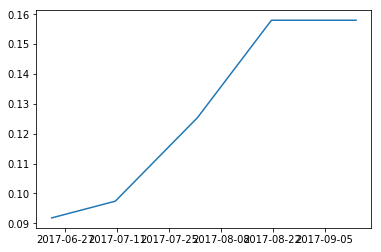

In [36]:
plt.figure()
plt.plot(Master['Zo'])
plt.show()